# Stromverbrauchsprognose unter Verwendung von Wetterdaten
In diesem Projekt soll anhand von bereitgestellten Wetter- und Energieverbrauchsinformationen eine Prognose für den Energieverbrauch 1h bzw. 24h nach vorne erstellt werden. Als Zeitraum werden hierfür die Monate Juni bis August 2011 untersucht.

## Setup

In [32]:
#
import pandas as pd
import numpy as np

#
import matplotlib.pyplot as plt

import seaborn as sns

import statsmodels.api as sm

#Show mulitple outputs within one kernel-----------------------
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

%matplotlib inline
#pd.set_option('display.float_format', lambda x: '%.3f' % x) #diplay command only show the first 5 digits

# 1. Überblick und  Datenbereinigung 
Wir arbeiten hierfür mit zwei Datensätzen.
* 'SystemLevelSummer.csv' enthält Informationen zum Stromverbrauch. 
* 'weatherDFLocalSummer.csv' enthält Wetterinformationen, welche im Wesentlichen vorhergesagt werden sollen.

## 1.1 Laden der Datensätze

In [33]:
powerDF = pd.read_csv('./data/SystemLevelSummer.csv')
weatherDF = pd.read_csv('./data/WeatherLocalSummer.csv')

In [34]:
powerDF.columns
powerDF.head()

Index(['#DATE', ' TOTAL_LOAD'], dtype='object')

,#DATE,TOTAL_LOAD
0,2011-06-01 00:15,639691.499583
1,2011-06-01 00:30,624777.006874
2,2011-06-01 00:45,610658.780201
3,2011-06-01 01:00,597351.542302
4,2011-06-01 01:15,583547.506936


In [35]:
weatherDF.columns
weatherDF.head()

Index(['# DATE', ' TEMPERATURE [F]', ' HUMIDITY [%]', ' PRESSURE [inHg]',
       ' WIND_SPEED [m/s]', ' RAINFALL [mm]'],
      dtype='object')

,# DATE,TEMPERATURE [F],HUMIDITY [%],PRESSURE [inHg],WIND_SPEED [m/s],RAINFALL [mm]
0,2011-05-30 17:00,86.635,51.563,29.941,7.523,0.0
1,2011-05-30 18:00,84.931,56.044,29.945,7.453,0.0
2,2011-05-30 19:00,83.100,61.551,29.952,6.930,0.0
3,2011-05-30 20:00,80.823,69.142,29.967,6.979,0.0
4,2011-05-30 21:00,79.305,75.395,29.983,6.677,0.0


## 1.2 Überarbeitung der Datenstruktur
Nachfolgend sollen die Datensätze so überarbeitet werden, damit diese im weiteren Verlauf sinnvoll untersucht werden können.  

### 1.2.1 Allgmeine Änderungen
Zunächst werden in den Spaltennamen nicht notwendige Leerzeichen entfernt. Zudem soll die Spalte "#DATE" in ein Datumsformat umgewandelt sowie anschließend als Index des Dataframes festgelegt werden, um Bezug zu einer Zeitskala herzustellen.  
Dabei wird sichergestellt, dass die Daten in aufsteigender Reihenfolge sortiert werden. Für eine bessere Übersicht werden noch Tag und Monat extrahiert.

In [36]:
def generalModification(df):
    #General Modifications---------------------
    df.columns = df.columns.str.replace(" ", "")

    #Date Modifications------------------------
    df['#DATE'] = pd.to_datetime(df['#DATE'])
    df = df.set_index('#DATE').sort_index()
    df.index = df.index.tz_localize('UTC') #ensure timezone-aware format for further modifications

    #Separate the datetime in separate columns
    df['MONTH'] = df.index.month
    df['DAY'] = df.index.day

    return df

In [37]:
powerDF = generalModification(powerDF)
weatherDF = generalModification(weatherDF)

### 1.2.2 Überprüfung auf Datenlücken
Wir wollen NaN Werte in unserem Datensatz ausschließen, da diese das Arbeiten mit den Daten erschweren und beim Auftreten genauer betrachtet werden müssten.  

In [38]:
#detect NaN values in the two df
any(map(lambda df: df.isna().any().any(), [powerDF, weatherDF]))

False

Zudem überprüfen wir gleich, ob wir Lücken innerhalb der Daten haben, also ob wir es mit einer kontinuierlichen Datenerfassung zu tun haben.  
Dazu betrachten wir jeweils die Differenz zweier aufeinanderfolgender Einträge und es soll bestimmt werden, ob diese von der zu Erwartetenden abweicht. Diese leiten wir aus den Tabellen in 1.1 ab.
  
Dabei erwarten wir für powerDF einen Abstand von 15min und für weatherDF einen Abstand von 60min.

In [39]:
#Ensure equal time periods between data
(powerDF.index.diff()[1:] == pd.Timedelta(minutes=15)).all()
(weatherDF.index.diff()[1:] == pd.Timedelta(minutes=60)).all()

True

True

Die Zeitabstände zwischen je zwei Daten sind stets identisch, somit sind die Daten kontinuierlich erfasst worden.

### 1.2.3 Einschränkung der Zeiträume
Die Stromverbrauchsdaten und Wetterdaten können nur in Kombination sinnvoll betrachtet werden. Dementsprechend ist nur der Zeitintervall relevant, in dem sich die Datenerfassung überschneidet. 
   
Aus dem Datensatz mit dem Stromverbrauch ist zu erkennen, dass die Messwerte im Zeitraum vom 01.06.2011 ab 02:00 Uhr bis 01.09.2011 00:00 Uhr aufgenommen worden sind. Der Datensatz mit den Wetterdaten hingegen bezieht sich auf den Zeitraum 30.05.2011 ab 17:00 Uhr bis 01.09.2011 16:00 Uhr. Somit liegen bei letzterem Datensatz mehr Werte vor als beim ersten, was auch am unterschiedlichen Count-Wert in der Daten-Zusammenfassung zu erkennen ist.  
  
Für den Startpunkt ist es der spätere erste Eintrag beider Datensätze zu wählen für den Endpunkt der frühere Endpunkt. Somit ergibt sich ein eingegrenzter Zeitraum zwischen dem 01.06.2011 00:30 Uhr nd 01.09.2011 00:00 Uhr.

In [40]:
print(len(powerDF), len(weatherDF))

powerDF.iloc[[1, -1]]
weatherDF.iloc[[1, -1]]

8832 2256


,TOTAL_LOAD,MONTH,DAY
#DATE,,,
2011-06-01 00:30:00+00:00,624777.006874,6,1
2011-09-01 00:00:00+00:00,768109.384737,9,1


,TEMPERATURE[F],HUMIDITY[%],PRESSURE[inHg],WIND_SPEED[m/s],RAINFALL[mm],MONTH,DAY
#DATE,,,,,,,
2011-05-30 18:00:00+00:00,84.931,56.044,29.945,7.453,0.0,5,30
2011-09-01 16:00:00+00:00,95.118,36.018,29.847,5.534,0.0,9,1


In [41]:
#Determine start and endtime 
start_date = max(powerDF.index.min(), weatherDF.index.min())
end_date = min(powerDF.index.max(), weatherDF.index.max())

#Crop the dataframes according to the overlapping intervall
powerDF = powerDF.loc[start_date:end_date]
weatherDF = weatherDF.loc[start_date:end_date]

### 1.2.4 Spezielle Überarbeitung powerDF
Da die Zeitabstände in powerDF 15 Minuten betragen und in weatherDF stündlich aufgenommene Messwerte vorliegen, soll im Folgenden der Dataframe powerDF überarbeitet bzw. an den Wetter-Datensatz angepasst werden.  
Weil es in beiden Datensätzen keine Lücken gibt, können in powerDF die einzelnen Werte zu Stundenwerte zusammengefasst werden.
  
Dabei verwerfen wir den ersten und letzen Eintrag, da wir hierfür keine volle Stunde erhalten würden und somit die Puntke nicht mit dem Rest vergleichbar wären.

In [42]:
#Resample the TOTAL_LOAD values to the summed load and keep DAY and MONTH
powerDF = powerDF.resample('h').agg({
    'TOTAL_LOAD': 'sum',
    'MONTH': 'first',
    'DAY': 'first'
})[1:-1]


<span style="color:red">Die Einträge von powerDF haben aktuell fünf Nachkommastellen. ....</span>

In [43]:
powerDF['TOTAL_LOAD'] = powerDF['TOTAL_LOAD'].round(1)

### 1.2.5 Spezielle Überarbeitung weatherDF
Da in Deutschland bei Temperaturmessungen die Einheit Celsius gängiger ist als Fahrenheit, wird im Folgenden die Spalte "TEMPERATURE[F]" umgwandelt. Ebenso wird bar als Einheit für den Druck verwendet.

In [44]:
#Adjust Fahrenheit to Celsius
weatherDF['TEMPERATURE[F]'] = (weatherDF['TEMPERATURE[F]']-32)/1.8
weatherDF = weatherDF.rename(columns={'TEMPERATURE[F]': 'TEMPERATURE[C]'})

#Adjust inHg to bar
weatherDF['PRESSURE[inHg]'] = (weatherDF['PRESSURE[inHg]'])*0.03386
weatherDF = weatherDF.rename(columns={'PRESSURE[inHg]': 'PRESSURE[bar]'})

## 1.3 Überblick über die Daten 
Zunächst soll sich von den Datensätzen ein grober Überblick verschaffen werden, um sie gegebenenfalls sinnvoll zu bearbeiten bzw. aneinander anzupassen.


In [45]:
powerDF.columns
powerDF

Index(['TOTAL_LOAD', 'MONTH', 'DAY'], dtype='object')

,TOTAL_LOAD,MONTH,DAY
#DATE,,,
2011-06-01 01:00:00+00:00,2312632.3,6,1
2011-06-01 02:00:00+00:00,2155474.9,6,1
2011-06-01 03:00:00+00:00,2067450.6,6,1
2011-06-01 04:00:00+00:00,2086290.8,6,1
2011-06-01 05:00:00+00:00,2221951.8,6,1
...,...,...,...
2011-08-31 19:00:00+00:00,4691375.7,8,31
2011-08-31 20:00:00+00:00,4468301.9,8,31
2011-08-31 21:00:00+00:00,4089121.2,8,31


In [46]:
weatherDF.columns
weatherDF

Index(['TEMPERATURE[C]', 'HUMIDITY[%]', 'PRESSURE[bar]', 'WIND_SPEED[m/s]',
       'RAINFALL[mm]', 'MONTH', 'DAY'],
      dtype='object')

,TEMPERATURE[C],HUMIDITY[%],PRESSURE[bar],WIND_SPEED[m/s],RAINFALL[mm],MONTH,DAY
#DATE,,,,,,,
2011-06-01 01:00:00+00:00,24.351111,86.692,1.021387,2.488,0.0,6,1
2011-06-01 02:00:00+00:00,23.909444,88.306,1.021488,1.053,0.0,6,1
2011-06-01 03:00:00+00:00,23.360000,90.432,1.021421,0.688,0.0,6,1
2011-06-01 04:00:00+00:00,22.806111,92.432,1.021488,0.409,0.0,6,1
2011-06-01 05:00:00+00:00,22.341111,93.320,1.021963,0.113,0.0,6,1
...,...,...,...,...,...,...,...
2011-08-31 20:00:00+00:00,31.151667,38.226,1.012279,4.247,0.0,8,31
2011-08-31 21:00:00+00:00,30.049444,48.333,1.013023,4.480,0.0,8,31
2011-08-31 22:00:00+00:00,29.117778,58.273,1.013667,3.775,0.0,8,31


In [47]:
powerDF.describe()
weatherDF.describe()

,TOTAL_LOAD,MONTH,DAY
count,2.207000e+03,2207.000000,2207.000000
mean,3.746181e+06,7.011328,15.843679
std,9.694753e+05,0.814287,8.852603
min,1.924936e+06,6.000000,1.000000
25%,2.855358e+06,6.000000,8.000000
50%,3.706778e+06,7.000000,16.000000
75%,4.583055e+06,8.000000,23.500000
max,5.719817e+06,8.000000,31.000000


,TEMPERATURE[C],HUMIDITY[%],PRESSURE[bar],WIND_SPEED[m/s],RAINFALL[mm],MONTH,DAY
count,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000,2208.000000
mean,29.016143,64.158212,1.012916,3.903246,0.007169,7.012228,15.836957
std,3.589466,18.294524,0.002487,1.931934,0.060354,0.815202,8.856232
min,19.231667,21.227000,1.006285,0.000000,-0.180000,6.000000,1.000000
25%,26.186389,47.577750,1.011263,2.474250,0.000000,6.000000,8.000000
50%,28.283056,66.711500,1.012786,3.709000,0.000000,7.000000,16.000000
75%,31.888056,81.220250,1.014344,5.292750,0.000000,8.000000,23.250000
max,39.385556,98.210000,1.022470,11.592000,1.800000,9.000000,31.000000


Im Folgenden werden die einzelnen Messwerte in Abhängigkeit von der Zeit geplottet.

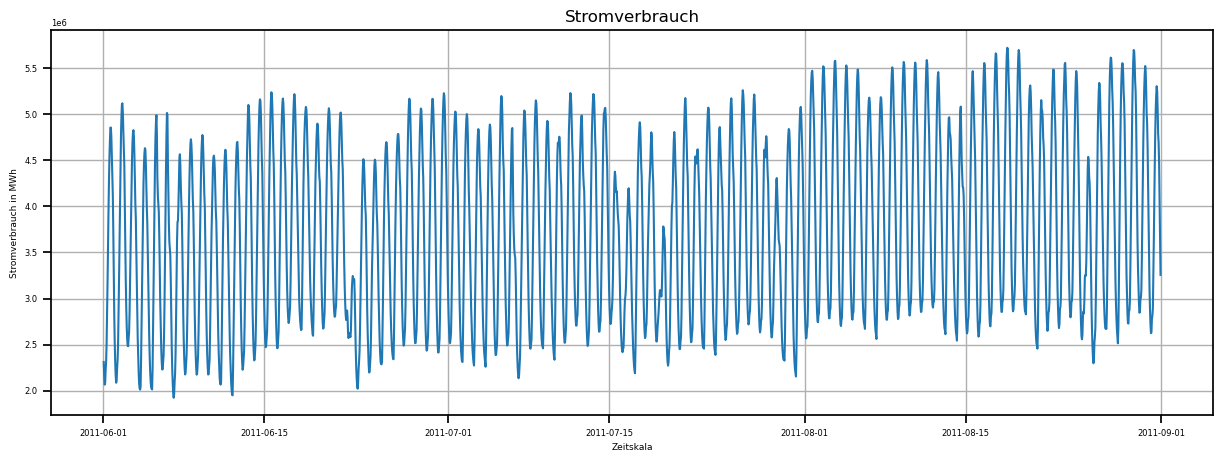

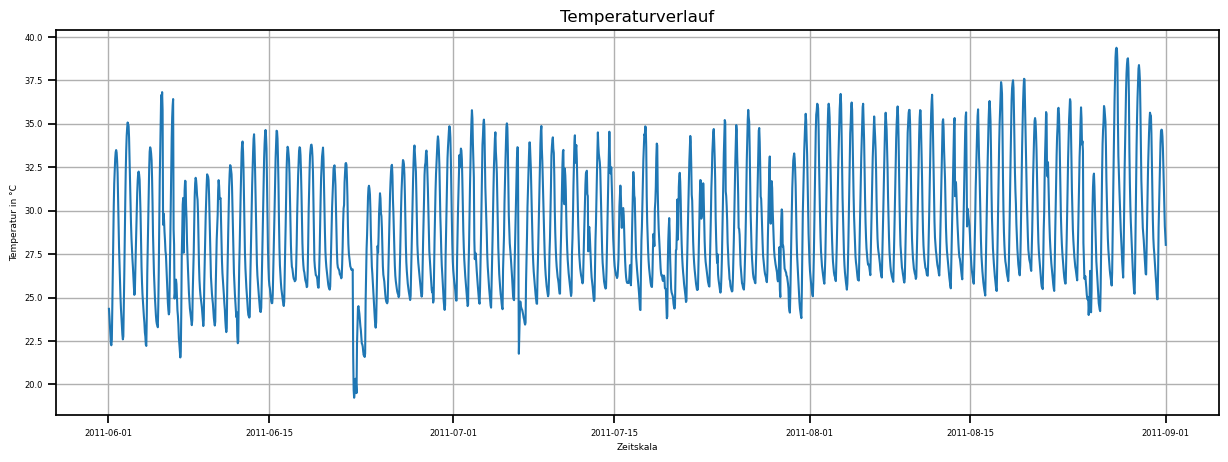

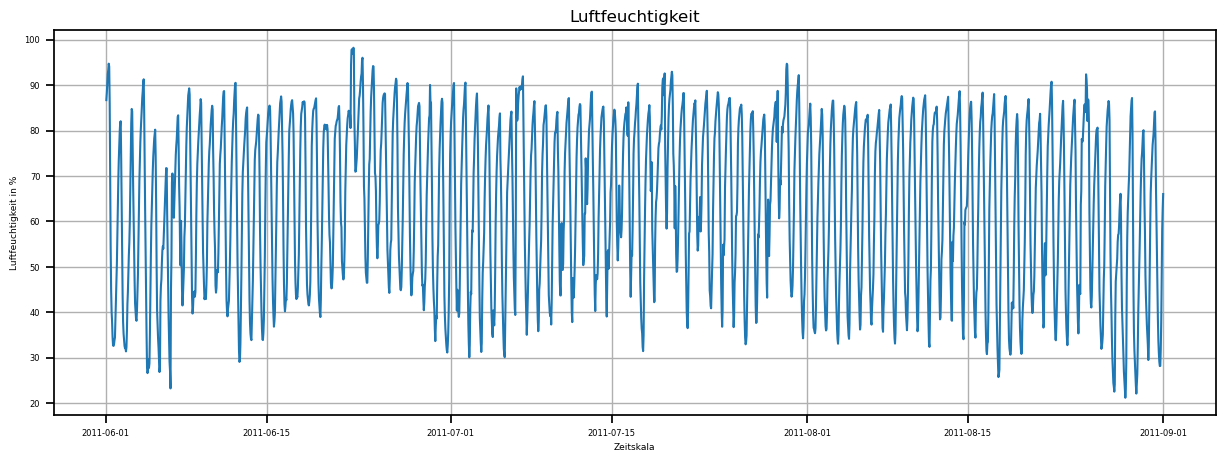

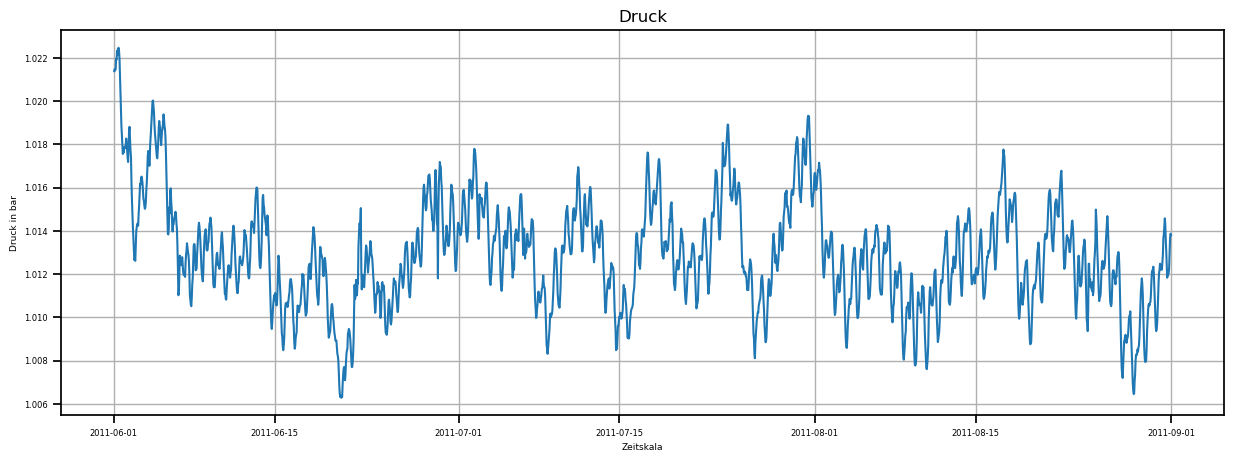

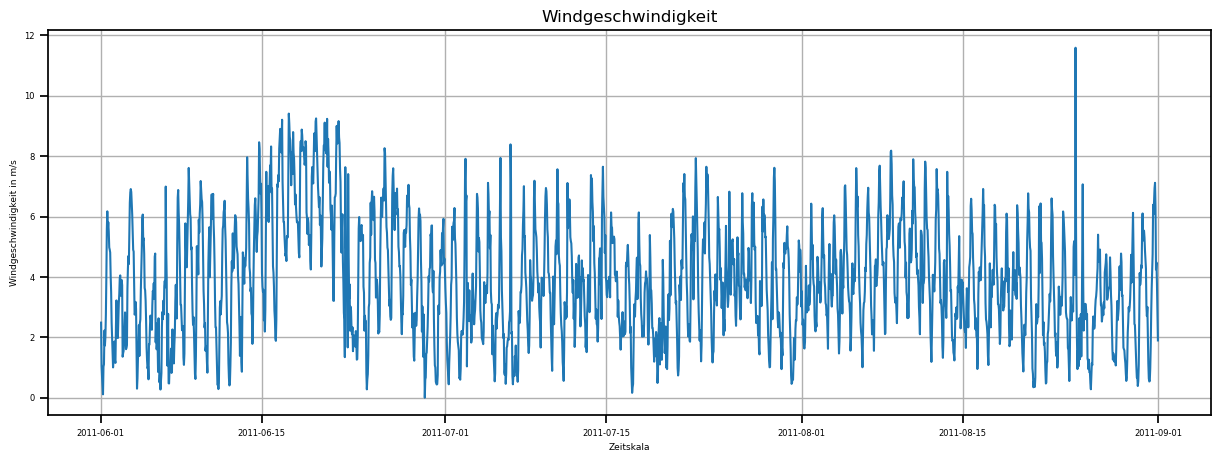

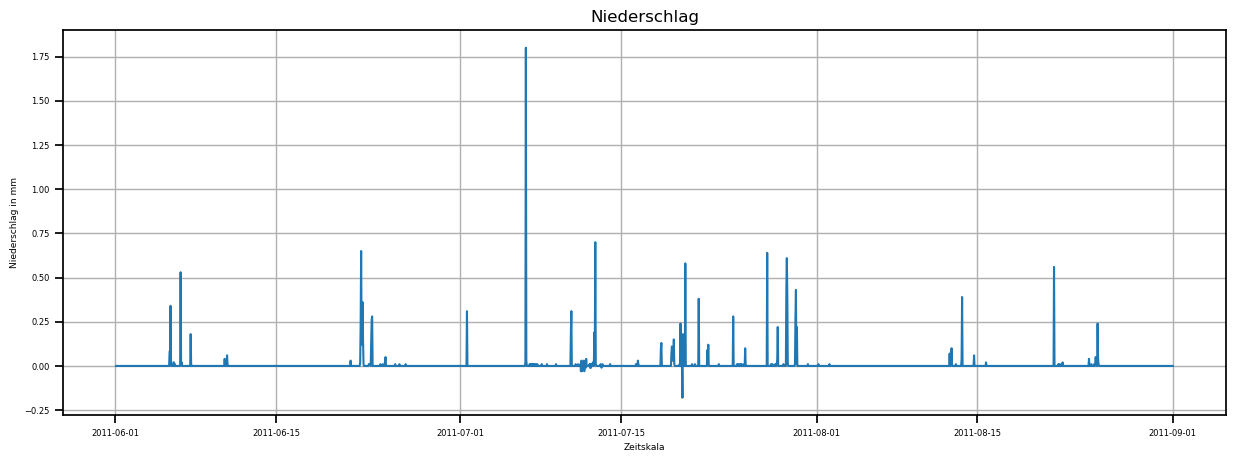

In [48]:
def plotDF(df, column, title, y_axis):
    plt.figure(figsize=(15, 5))

    plt.plot(df.index, df[column])

    plt.title(title)
    plt.xlabel('Zeitskala')
    plt.ylabel(y_axis)
    plt.grid(True)
    plt.show()

plotDF(powerDF, 'TOTAL_LOAD', 'Stromverbrauch', 'Stromverbrauch in MWh')
plotDF(weatherDF, 'TEMPERATURE[C]', 'Temperaturverlauf', 'Temperatur in °C')
plotDF(weatherDF, 'HUMIDITY[%]', 'Luftfeuchtigkeit', 'Luftfeuchtigkeit in %')
plotDF(weatherDF, 'PRESSURE[bar]', 'Druck', 'Druck in bar')
plotDF(weatherDF, 'WIND_SPEED[m/s]', 'Windgeschwindigkeit', 'Windgeschwindigkeit in m/s')
plotDF(weatherDF, 'RAINFALL[mm]', 'Niederschlag', 'Niederschlag in mm')

#### 1.3.1 Beschreibung der Datensätze
<span style="color:red">
Aus dem Datensatz mit dem Stromverbrauch ist bereits zu erkennen, dass die Messwerte im Zeitraum vom 01.06.2011 bis 01.09.2011 im 15-Minutentakt vollständig aufgenommen worden sind, welche vorhin jedoch in Stundenwerte umgwandelt worden sind. Der Datensatz mit den Wetterdaten hingegen bezieht sich auf den Zeitraum 30.05.2011 ab 17:00 Uhr bis 01.09.2011 16:00 Uhr. Somit liegen bei letzterem Datensatz mehr Werte vor als beim ersten, was auch am unterschiedlichen Count-Wert in der Daten-Zusammenfassung zu erkennen ist. In beiden Datensätzen werden jedoch vollständig die drei Sommermonate Juni, Juli und August für das Jahr 2011 betrachtet. In den Wetterdaten sind stündliche Messwerte zu Temperatur (in °C), Luftfeuchtigkeit (in %), Druck (in bar), Windgeschwindigkeit (in m/s) und Niederschlag (in mm) enthalten. </span>
  
  Sowohl in der Daten-Zusammenfassung als auch im Plot zum Niederschlag ist zu erkennen, dass es negative Messwerte gibt, was logischerweise nicht möglich ist und vermutlich Folge einer fehlerbehafteten Messung ist. Außerdem ist auffällig, dass im Zeitraum vom 01.07. bis 15.07 ein extrem hoher Wert für den Niederschlag zu erkennen ist, der laut Zusammenfassung 1,8mm beträgt.
  
  Auch bei der Windgeschwindigkeit ist ein Ausreißer zwischen 15.08. und 01.09. ersichtlich, der im Vergleich zu den restlichen Werten sehr hoch ist mit einer Geschwindigkeit von gerundet 11,59 m/s. Dabei liegt im gleichen Zeitraum auch eine kleine Unregelmäßigkeit im Plot zum Stromverbrauch vor, wobei später geklärt werden soll ob es hierfür einen Zusammenhang gibt.
  
  Zudem wird im Plot zum Stromverbrauch ersichtlich, dass sich im Zeitraum zwischen 15.06. und 01.07. ein Ausreißer befindet, da der Verbrauch an dieser Stelle für längere Zeit ziemlich gering ist. Auch bei den Wetterdaten zu Temperatur, Luftfeuchtigkeit, Windgeschwindigkeit und Niederschlag sind in selbigem Zeitraum Auffälligkeiten zu erkennen: Im Vergleich zu den restlichen Daten herrschte eine ziemlich hohe Windgeschwindigkeit sowie eine hohe Luftfeuchtigkeit und hoher Niederschlag, wohingegen die Temperatur eher niedrig war. Ebenso ist im Zeitraum vom 15.07. bis 01.08. ein Ausreißer im Stromverbrauch zu erkennen.   
  
  Die bisherigen Beobachtungen sowie die genauen Daten bzw. Zeiten werden jedoch erst im späteren Verlauf bei der Datenanalyse näher untersucht.

## 1.4 Datenbereinigung
Damit für die weitere Arbeit mit den Daten bzw. für die Erstellung der Prognosen sinnvolle Messwerte vorliegen, werden die bisherigen bereits überarbeiteten Daten bereinigt.

### 1.4.1 Einschränkung des Zeitintervalls
Wie bereits festgestellt worden ist, stimmen Beginn und Ende der Datenerfassung in den beiden Datensätzen nicht überein.   
Dies soll nun vereinheitlicht werden, indem wir den späteren Startzeitpunkt und den früheren Endzeitpunkt als gültiges Intervall wählen.

In [49]:
start_date = max(powerDF.index.min(), weatherDF.index.min())
end_date = min(powerDF.index.max(), weatherDF.index.max())

powerDF = powerDF.loc[start_date:end_date]
weatherDF = weatherDF.loc[start_date:end_date]

### 1.4.2 Bearbeitung unlogischer Werte
Im Großen und Ganzen haben wir logisch erscheinende Daten. Allerdings gibt es noch einige Ausreißer, die physikalisch nicht nachvollziehbar sind.   
  
So erhalten wir beispielsweise für den Niederschlag, wie vorhin bereits beobachtet, in vereinzelten Fällen negative Werte.   
Diese sollen nachfolgend detektiert und untersucht werden, wie am besten mit ihnen umgegangen werden soll.

Je nachdem wie die Daten aussehen, wollen wir diese beispielsweise

* durch predefinierte Standardwerte ersetzen z.B 0[mm]
* durch das positive Inverse ersetzen
* durch den Durschnitt umliegender Werte ersetzen

   
Natürlich könnten wir die betreffenden Reihen auch verwerfen; wie wir allerdings später sehen werden, steht dieser Parameter nicht wirklich im Zusammenhang mit dem zu prognostizierenden Stromverbrauch und wird später tendenziell als Ganzes verworfen.  
Da die Kontinuität der Daten für die Prognose wichtiger ist, wird nur dieser angepasst.   

In [50]:
negativRainDF = weatherDF[weatherDF['RAINFALL[mm]']<0]
negativRainDF

len(negativRainDF)

,TEMPERATURE[C],HUMIDITY[%],PRESSURE[bar],WIND_SPEED[m/s],RAINFALL[mm],MONTH,DAY
#DATE,,,,,,,
2011-07-11 12:00:00+00:00,32.641667,45.994,1.016139,3.053,-0.03,7,11
2011-07-11 14:00:00+00:00,34.343889,37.866,1.015055,3.484,-0.03,7,11
2011-07-11 19:00:00+00:00,31.836111,49.500,1.013057,6.569,-0.03,7,11
2011-07-11 22:00:00+00:00,28.277222,67.671,1.014818,5.191,-0.01,7,11
2011-07-12 07:00:00+00:00,25.927778,85.567,1.014750,2.129,-0.01,7,12
2011-07-12 09:00:00+00:00,28.318889,72.986,1.015563,4.433,-0.01,7,12
2011-07-13 07:00:00+00:00,24.918333,88.564,1.013565,1.511,-0.01,7,13
2011-07-20 08:00:00+00:00,25.977222,85.412,1.013802,1.716,-0.18,7,20


8

Wir erhalten für acht Reihen negative Niederschlagswerte.  

Vergleichen wir die umliegenden Niederschlagswerte mit den negativen, so fällt auf, dass abseits vom Vorzeichen die Größenordnung sehr ähnlich oder sogar gleich ist.  
Unten aufgeführt sind die Reihen der letzten drei betroffenen inkl. unmittelbar umliegender Werte, ähnlich verhält sich diese Beobachtung beim Rest.
  
Dies legt nahe, dass nur das Vorzeichen falsch ist, die Zahlenwerte allerdings richtig sind. Wir entschließen uns somit jeweils den Betrag des Niederschlages als tatsächlichen Wert anzunehmen, um das Problem zu beseitigen.

In [51]:
for index in negativRainDF.index[-3:]:
    #Current index position in the weatherDF of correspoding negativRainDF
    idx_pos = weatherDF.index.get_loc(index)

    #DF with surrounding rows
    weatherDF.iloc[idx_pos-1:idx_pos +2]


,TEMPERATURE[C],HUMIDITY[%],PRESSURE[bar],WIND_SPEED[m/s],RAINFALL[mm],MONTH,DAY
#DATE,,,,,,,
2011-07-12 08:00:00+00:00,27.197222,79.320,1.015224,3.014,0.01,7,12
2011-07-12 09:00:00+00:00,28.318889,72.986,1.015563,4.433,-0.01,7,12
2011-07-12 10:00:00+00:00,29.417222,66.580,1.015868,3.390,0.01,7,12


,TEMPERATURE[C],HUMIDITY[%],PRESSURE[bar],WIND_SPEED[m/s],RAINFALL[mm],MONTH,DAY
#DATE,,,,,,,
2011-07-13 06:00:00+00:00,24.800000,88.396,1.013227,1.989,0.00,7,13
2011-07-13 07:00:00+00:00,24.918333,88.564,1.013565,1.511,-0.01,7,13
2011-07-13 08:00:00+00:00,26.798889,80.056,1.014039,2.797,0.00,7,13


,TEMPERATURE[C],HUMIDITY[%],PRESSURE[bar],WIND_SPEED[m/s],RAINFALL[mm],MONTH,DAY
#DATE,,,,,,,
2011-07-20 07:00:00+00:00,24.524444,92.167,1.013261,0.950,0.00,7,20
2011-07-20 08:00:00+00:00,25.977222,85.412,1.013802,1.716,-0.18,7,20
2011-07-20 09:00:00+00:00,27.728889,74.943,1.014107,3.259,0.18,7,20


In [52]:
#Adjust negative value to positive value
weatherDF.loc[:,'RAINFALL[mm]'] = weatherDF.loc[:,'RAINFALL[mm]'].abs()

# 2. Datenanalyse

## 2.0 Kombination beider Datensätze 
Ab hier werden wir Funtkionen verwenden, für die es sinnvoll ist alle Daten in einer Struktur auffinden zu können. Da die Zeiträume und Erfassungsabstände unserer Datensätze übereinstimmen, können wir diese einfach am Index mergen.
Zudem defnieren wir eine Liste mit den Features und eine mit den Targets. Diese werden vorerst alle Wetterdaten und die Stromdaten sein.   

In [53]:
necessaryCol = powerDF.columns.difference(weatherDF.columns) #excludes duplicate columns
weather_powerDF = pd.merge(powerDF[necessaryCol], weatherDF, on='#DATE')

In [54]:
features = weatherDF.columns
targets = []

## 2.1 Linearität 

## 2.2 Periodizität
Widerholende Struktur innerhalb der daten zu beobachten, speziell in TEmperatur, Feuchtigkeit; Windstärke und Stromverbrauch. Deswegen genauere Betrachtung

<Axes: xlabel='#DATE'>

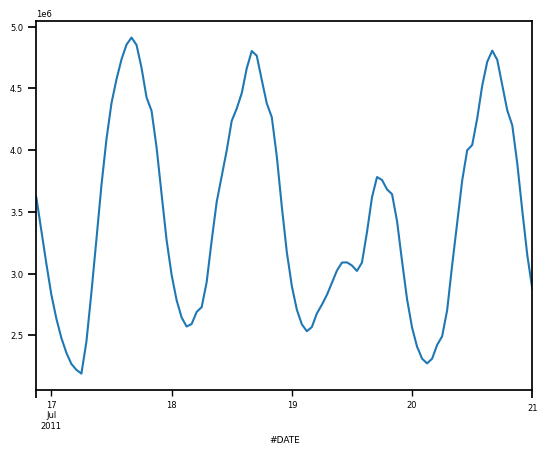

In [55]:
#PLot mit den relevanten Spalten aus beiden Dataframes
powerDF['TOTAL_LOAD'][1100:1200].plot()

## 2.3 Korrelation 

<Axes: >

Text(0.5, 1.0, 'Korrelationsmatrix der Wetter- und Stromdaten')

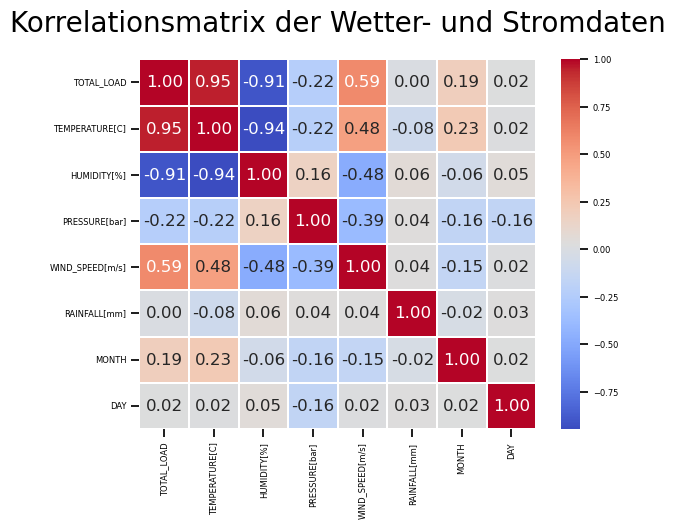

In [56]:
#Define the Korrelation 
corrMatrix = weather_powerDF.corr()

#Plot the corr Matrix
sns.heatmap(corrMatrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.2)
plt.title('Korrelationsmatrix der Wetter- und Stromdaten', size=20, pad = 20)
plt.show()

In [57]:
#Define settings for the pairplot
sns.set_context("notebook", rc={"axes.labelsize": 6.5, "xtick.labelsize": 6, "ytick.labelsize": 6})

#sns.pairplot(weather_powerDF, height=1.1, kind="hist")

Was ist zu sehen? 

p Value etc. 

## 2.4 Ausreißer 

#Funktion schreiben die diese detektiert
22.06.2011 
https://www.spiegel.de/panorama/regen-hagel-sturm-tausende-haushalte-nach-unwetter-ohne-strom-a-769966.html 

19.07.2011 ??? 

<Axes: xlabel='#DATE'>

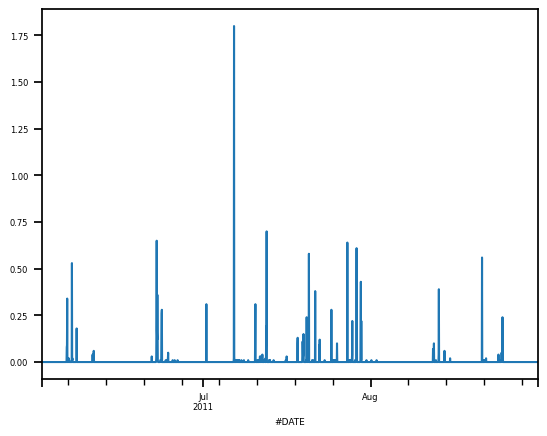

In [58]:
weatherDF['RAINFALL[mm]'].plot()

# 3. Vorbereitung für die Porgnosemodelle
Nun widmen wir uns der Aufgabenstellung den Stromverbrauch für 1h bzw. 24h nach vorne vorherzusagen. Dazu sollen verschiedene Modelle zur Prognose der Daten ausprobiert und miteinander verglichen werden.  

Zunächst müssen wir den zu Datetime gesetzten Index in unserem weather_powerDF Datensatz zurücksetzen, um eine Kompatibilität der Datenstruktur mit den zukünftig angewandten Modellen zu gewährleisten. DAbei wird der Ursprüngliche INdex als Spalte dem DataFrame hinzugefüht, was uns allerdings nicht weiter stört, da die Features und Targets separat definiert sind.

## 3.1 Anpassung der Targets
Jetzt passen wir die Datensätze so an, dass wir die Werte der Stromverbrauchs um 1h bzw 24H nach vorne ziehen und somit eine entsprechende versetzte Zurodnung zu den Wetterdaten erzeugen.  
So wird gewährleistet, dass die Modelle zu den aktuellen Wetterdaten die zukünftigen Stromverbrauchsdaten als Referenz besitzen und darauf traniert werden Prognosen zu erstellen und nicht nur den aktuellen Verbrauch einzuschätzen.

In [59]:
#Add new columns to the targets list
targets += ['TOTAL_LOAD_1H', 'TOTAL_LOAD_24H']

weather_powerDF[targets[0]] = pd.DataFrame(weather_powerDF.loc[:, 'TOTAL_LOAD'].shift(-1))
weather_powerDF[targets[1]] = pd.DataFrame(weather_powerDF.loc[:, 'TOTAL_LOAD'].shift(-24))

## 3.2 Train-Test Split
Da unser Datensatz nur drei Monate eines Jahres beinhaltet, benutzen wir einfachheitshalber die ersten 80% der Daten als unsere Trainingsdaten und die restlichen 20% als Testdaten.  

In [60]:
#Position of the row next to 80% of the data
index80percent = round(len(weather_powerDF)*0.8)

weather_powerDF_train = weather_powerDF[:index80percent]
weather_powerDF_test = weather_powerDF[index80percent:]

Wir wollen unserern Datensatz in Trainingsdaten und Testdaten unterteilen. Dazu wählen wir je die Feature und Target Spalten.

In [61]:
#Train and Test Dataset for the Features
X_train = weather_powerDF_train[features]
X_test = weather_powerDF_test[features]

#Train and Test Dataset for the Targets 1H and 24H ahead
y_1H_train = weather_powerDF_train[targets[0]]
y_1H_test = weather_powerDF_test[targets[0]]
y_24H_train = weather_powerDF_train[targets[1]]
y_24H_test = weather_powerDF_test[targets[1]]